<a href="https://colab.research.google.com/github/vinaykeshava/anime-api/blob/main/image_exe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**LET US SEE THE CODING PART OF OUR PROJECT**

In [1]:
import string
import numpy as np
from PIL import Image  #pyton imaging library PIL
import os   #helps to deal with creating and fetching files from different directories          
from pickle import dump, load #serializing and deserializing a Python object structure.
import numpy as np

from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical #it coverts numpy arrays(has integer values) into matrix having binary values
from keras.layers.merge import add 
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout

# small library for seeing the progress of loops.
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


***DESCRIPTION CLEANING***

In [3]:
def load_doc(filename):
    # Opening the file as read only
    # filename = os.path.join(root_captioning,\
    #         'Flickr8k.token.txt')
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

In [4]:
# get all imgs with their captions
def all_img_captions(filename):
    # filename = os.path.join(root_captioning,\
    #         'Flickr8k.token.txt')
    file = load_doc(filename)
    captions = file.split('\n')
    descriptions ={}
    for caption in captions[:-1]:
        img, caption = caption.split('\t')
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [ caption ]
        else:
            descriptions[img[:-2]].append(caption)

    # print(descriptions['1000268201_693b08cb0e.jpg'])
    return descriptions

In [5]:
#Data cleaning- lower casing, removing puntuations and words containing numbers
def cleaning_text(captions):
    table = str.maketrans('','',string.punctuation) #str.maketrans("str1","str2","str3"),str3:The strings to be deleted
    for img,caps in captions.items(): 
        for i,img_caption in enumerate(caps): #img_caption will have one caption per iteration and i will have index starting from 0
            img_caption.replace("-"," ")
            desc = img_caption.split()
            #converts to lowercase
            desc = [word.lower() for word in desc]
            #remove punctuation from each token
            desc = [word.translate(table) for word in desc]
            #remove hanging 's and a 
            desc = [word for word in desc if(len(word)>1)]
            #remove tokens with numbers in them
            desc = [word for word in desc if(word.isalpha())]
            #convert back to string
            img_caption = ' '.join(desc)
            captions[img][i]= img_caption
    return captions

In [6]:
# build vocabulary of all unique words
def text_vocabulary(descriptions):
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]] #here we are updating the vocab set with new and uique words 
    return vocab

In [7]:
#All descriptions in one file 
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()

In [8]:
# dataset_text = "text"
# dataset_images = "images"
root_captioning = '/content/drive/MyDrive/icg/icgg/text'
root_caption = '/content/drive/MyDrive/icg/icgg'
root_img = '/content/drive/MyDrive/icg/icgg/Images'


In [9]:
#we prepare our text data
# filename = dataset_text + "/" + "Flickr8k.token.txt"
filename = os.path.join(root_captioning,\
            'Flickr8k.token.txt')


#loading the file that contains all data\
#mapping them into descriptions dictionary img to 5 captions
descriptions = all_img_captions(filename)


# use to show the elements in each key ie caption of each image
# print(descriptions["1000268201_693b08cb0e.jpg"])
print("Length of descriptions =" ,len(descriptions))


#cleaning the descriptions
clean_descriptions = cleaning_text(descriptions)
# print(clean_descriptions["1000268201_693b08cb0e.jpg"])

#building vocabulary 
vocabulary = text_vocabulary(clean_descriptions)


# print(vocabulary)
print("Length of vocabulary = ", len(vocabulary))


#saving each description to file 
save_descriptions(clean_descriptions,os.path.join(root_caption,\
                                                  'descriptions.txt'))


Length of descriptions = 8092
Length of vocabulary =  8763


***FEATURE EXTRACTION***

In [10]:
def extract_features(directory):
        model = Xception( include_top=False, pooling='avg' )
        features = {}
        for img in tqdm(os.listdir(directory)):
            filename = directory + "/" + img
            image = Image.open(filename)
            image = image.resize((299,299)) #input image should be 299*299*3
            image = np.expand_dims(image, axis=0)
            # image = preprocess_input(image)
            #Normalizing the image by reducing the pixel values between -1 to 1
            image = image/127.5
            image = image - 1.0

            feature = model.predict(image)    #using the xception model we are predicting the image
            features[img] = feature           #and we are storing that predicted feature into features dictionary
        return features
        
#this is a very time consuming process.
#2048 feature vector
# features = extract_features(os.path.join(root_img))
# dump(features, open("Features2.p","wb"))

In [11]:
features = load(open(os.path.join(root_caption,\
                                  'features.p'),"rb"))

In [12]:
 #This will load the text file in a string and will return the list of image names.
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split("\n")[:-1]
    return photos

In [13]:
def load_clean_descriptions(filename, photos): 
    #loading clean_descriptions
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):
        words = line.split()
        if len(words)<1 :
            continue
        image, image_caption = words[0], words[1:]
        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<start> ' + " ".join(image_caption) + ' <end>'
            descriptions[image].append(desc)
    # print(image,image_caption)
    return descriptions

In [14]:
def load_features(photos):
    #loading all features
    all_features = load(open(os.path.join(root_caption,\
                                  'features.p'),"rb"))
    #selecting only needed features
    features = {k:all_features[k] for k in photos}
    # print(features)
    # print(type(features))
    return features


In [15]:
print(len(features))

8091


In [16]:
# filename = dataset_text + "/" + "Flickr_8k.trainImages.txt"
filename = os.path.join(root_captioning,\
            "final8k.txt")
#train = loading_data(filename)
train_imgs = load_photos(filename)
# print(train_imgs[1000268201_693b08cb0e])
train_descriptions = load_clean_descriptions(os.path.join(root_caption,\
                                                          "descriptions.txt"), train_imgs)
train_features = load_features(train_imgs)
# res = list(train_descriptions.keys())[0]
# print(str(res))
# print(type(train_descriptions))

In [17]:
#converting dictionary to clean list of descriptions
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc


***TOKENIZING***

In [18]:
#@title Default title text
# desc_list = dict_to_list(train_descriptions)
# print(desc_list)


from keras.preprocessing.text import Tokenizer
def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer
# give each word an index, and store that into tokenizer.p pickle file
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('/content/drive/MyDrive/icg/icgg/tokenizer.p', 'wb'))
# tokenizer = load(open(os.path.join(root_caption,\
#                                   'tokenizer.p'),"rb"))

vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)
print(type(tokenizer))

8657
<class 'keras_preprocessing.text.Tokenizer'>


In [19]:
#calculate maximum length of descriptions
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)
    
max_length = max_length(descriptions)
max_length

32

In [20]:
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield [[input_image, input_sequence], output_word]

In [22]:
def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        print(len(seq))
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            # print(in_seq)
            #*pad_sequences is used to ensure that all sequences in a list have the same length.By default this is done by padding 0 
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0] 
            # print(in_seq)
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
#             print(vocab_size)
            # print(out_seq)
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
        # print(*X2)
    return np.array(X1), np.array(X2), np.array(y)

In [23]:
[a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_length))
a.shape, b.shape, c.shape

16
7
8
10
11


((47, 2048), (47, 32), (47, 8657))

In [24]:
# from keras.utils import plot_model
# tf.keras.utils.plot_model(
# model, to_file='model.png', show_shapes=False, show_dtype=False,
# show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
# )

# from keras.utils.vis_utils import plot_model
# tf.keras.utils.plot_model(
# model, to_file='model.png', show_shapes=False, show_dtype=False,
# show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
# )

from keras.utils.vis_utils import plot_model
# define the captioning model
def define_model(vocab_size, max_length):

    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    # Dropout is a technique used to prevent a model from overfitting
    fe1 = Dropout(0.5)(inputs1)
    # Dense implements the operation: output = activation(dot(input, kernel) + bias)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    # add()-->It takes  input as a list of tensors, all of the same shape, and returns a single tensor (also of the same shape).
    decoder1 = add([fe2, se3])  
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # summarize model
    print(model.summary())
    # plot_model(model, to_file='model.png', show_shapes=True)

    return model

***TRAINING OUR MODEL***

In [27]:
# train our model
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)


model = define_model(vocab_size, max_length)
epochs = 10
steps = len(train_descriptions)
# # making a directory models to save our models
# os.mkdir("models")
# for i in range(epochs):
#     generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
#     model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)
#     model.save("models/model_" + str(i) + ".h5")

Dataset:  7999
Descriptions: train= 7999
Photos: train= 7999
Vocabulary Size: 8657
Description Length:  32
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 32, 256)      2216192     ['input_4[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 2048)         0           ['input_3[0][0]']  

In [ ]:
# from google.colab import files
# for i in range(0,10)
#   files.download('/content/models/model_"+ str(i) + ".h5')

***LETS GENERATE THE CAPTIONS FOR IMAGES***




start dog is running through the water end


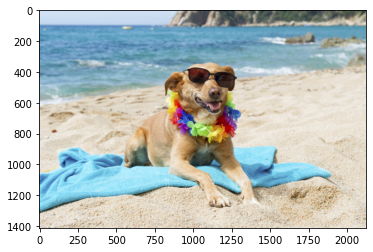

In [29]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import argparse


# ap = argparse.ArgumentParser()
# ap.add_argument('-i', '--image', required=True, help="Image Path")
# args = vars(ap.parse_args())
# img_path = args['image']

def extract_features(filename, model):
        try:
            image = filename

        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
     if index == integer:
         return word
    return None


def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text


#path = 'Flicker8k_Dataset/111537222_07e56d5a30.jpg'
max_length = 32
tokenizer = load(open(os.path.join(root_caption, \
                                   'tokenizer.p'),"rb"))
# all_features = load(open(os.path.join(root_caption,\
                                  # 'features.p'),"rb")) 
model = load_model(os.path.join('/content/drive/MyDrive/icg/icgg/model/model_new_1',\
                                'model_90.h5'))
xception_model = Xception(include_top=False, pooling="avg")


img = Image.open(os.path.join('/content/drive/MyDrive/icg/icgg/test_im',\
                              'image2.jpg'))
photo = extract_features(img, xception_model)
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)




start is in street dog on girl walk two sitting the man having end


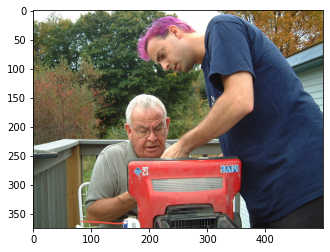

In [35]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import argparse


# ap = argparse.ArgumentParser()
# ap.add_argument('-i', '--image', required=True, help="Image Path")
# args = vars(ap.parse_args())
# img_path = args['image']

def extract_features(filename, model):
        try:
            image = filename

        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
     if index == integer:
         return word
    return None


def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text


#path = 'Flicker8k_Dataset/111537222_07e56d5a30.jpg'
max_length = 72
tokenizer = load(open(os.path.join('/content/drive/MyDrive/icg_ficker_30k', \
                                   'tokenizer.p'),"rb"))
# all_features = load(open(os.path.join(root_caption,\
                                  # 'features.p'),"rb")) 
model = load_model(os.path.join('/content/drive/MyDrive/icg_ficker_30k',\
                                'model_0.h5'))
xception_model = Xception(include_top=False, pooling="avg")


img = Image.open(os.path.join('/content/drive/MyDrive/flickr30k_images/flickr30k_images',\
                              '51565199.jpg'))
photo = extract_features(img, xception_model)
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

# 4855810908 -no
# 4700695576 - no
# 230105501 - no
# 515684832 - no
# 51565199 - no

***THANK YOU***
